# Goddard problem

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Research/logiciels/dev/control-toolbox/BVP-DAE/julia`


In [2]:
using JSON
import Plots: plot, plot!, Plots

## BVP-DAE

In [3]:
struct GoddardBVPSol

    t
    h
    v
    m
    ph
    pv
    pm
    u
    tf
    obj

    function GoddardBVPSol()

        data = JSON.parsefile("../python/Goddard/results_goddard_primal_dual.json")

        t  =  data["t"]
        u  =  data["z"][1, :][1]
        h  =  data["xp"][1, :][1]
        v  =  data["xp"][2, :][1]
        m  =  data["xp"][3, :][1]
        ph = -data["xp"][5, :][1]
        pv = -data["xp"][6, :][1]
        pm = -data["xp"][7, :][1]
        
        tf  = data["xp"][4, 1][1]
        obj = h[end]

        # from Paul, the problem is defined in Lagrange form with normalize time
        p⁰ = -1
        ph = (ph .- p⁰)
        pv = pv
        pm = pm

        return new(t, h, v, m, ph, pv, pm, u, tf, obj)

    end

end

sol_bvp = GoddardBVPSol()

println("Final time:      ", sol_bvp.tf)
println("Objective value: ", sol_bvp.obj)

nothing

Final time:      0.2040494160682758
Objective value: 1.012717589749775


In [4]:
function plot(sol::GoddardBVPSol; kwargs...)

    t  = sol.t
    h  = sol.h
    v  = sol.v
    m  = sol.m
    u  = sol.u
    ph = sol.ph
    pv = sol.pv
    pm = sol.pm
    tf = sol.tf

    plt_h  = Plots.plot(t*tf, h;  label="h")
    plt_v  = Plots.plot(t*tf, v;  label="v")
    plt_m  = Plots.plot(t*tf, m;  label="m")
    plt_ph = Plots.plot(t*tf, ph; label="ph")
    plt_pv = Plots.plot(t*tf, pv; label="pv")
    plt_pm = Plots.plot(t*tf, pm; label="pm")
    plt_u  = Plots.plot(t*tf, u;  label="u")

    plt_state   = Plots.plot(plt_h,  plt_v,  plt_m;  layout=(3, 1))
    plt_costate = Plots.plot(plt_ph, plt_pv, plt_pm; layout=(3, 1))

    plt_xp = Plots.plot(plt_state, plt_costate; layout=(1, 2))

    layout = Plots.grid(2, 1, heights=[3/4, 1/4])
    return Plots.plot(plt_xp, plt_u; layout=layout, kwargs...)

end

function plot!(p::Plots.Plot, sol::GoddardBVPSol; kwargs...)
    
    t  = sol.t
    h  = sol.h
    v  = sol.v
    m  = sol.m
    u  = sol.u
    ph = sol.ph
    pv = sol.pv
    pm = sol.pm
    tf = sol.tf

    Plots.plot!(p[1], t*tf, h;  label="h (BVP)", kwargs...)
    Plots.plot!(p[2], t*tf, v;  label="v (BVP)", kwargs...)
    Plots.plot!(p[3], t*tf, m;  label="m (BVP)", kwargs...)
    Plots.plot!(p[4], t*tf, ph; label="ph (BVP)", kwargs...)
    Plots.plot!(p[5], t*tf, pv; label="pv (BVP)", kwargs...)
    Plots.plot!(p[6], t*tf, pm; label="pm (BVP)", kwargs...)
    Plots.plot!(p[7], t*tf, u;  label="u (BVP)", kwargs...)

end
nothing

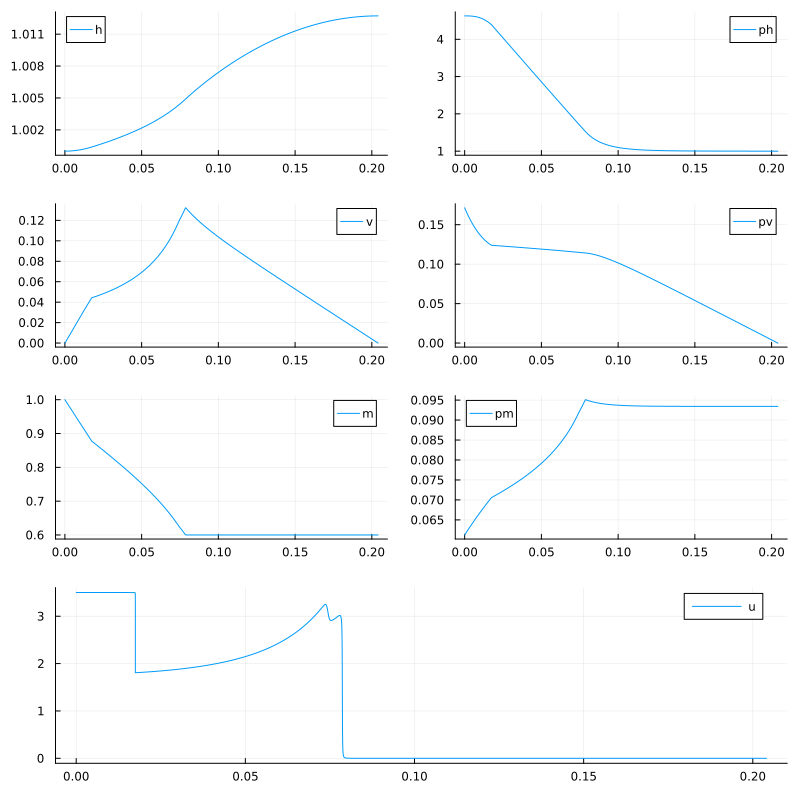

In [5]:
plt_bvp = plot(sol_bvp; size=(800, 800))

## Direct method

In [6]:
using OptimalControl

const t0 = 0      # initial time
const h0 = 1      # initial altitude
const v0 = 0      # initial speed
const m0 = 1      # initial mass
const mf = 0.6    # final mass to target
const Tmax = 3.5

@def ocp begin # definition of the optimal control problem

    tf ∈ R, variable
    t ∈ [ t0, tf ], time
    x = (h, v, m) ∈ R³, state
    u ∈ R, control

    x(t0) == [ h0, v0, m0 ]
    m(tf) == mf,         (1)
    0 ≤ u(t) ≤ Tmax
    h(t) ≥ h0
    q(h(t), v(t)) ≤ 0

    ẋ(t) == F0(x(t)) + u(t) * F1(x(t))

    h(tf) → max

end;

# Dynamics
const Cd = 310
const β = 500
const b = 2
const qmax = 10

d(h, v) = Cd * v^2 * exp(-β*(h - 1)) # drag force
q(h, v) = 20 * d(h, v) - qmax        # dynamic pressure

F0(h, v, m) = [ v, -d(h, v)/m - 1/h^2,  0 ]
F1(h, v, m) = [ 0,                1/m, -b ]

F0(x) = F0(x...)
F1(x) = F1(x...)

nothing

In [19]:
using NLPModelsIpopt
direct_sol = solve(ocp; grid_size=500, print_level=4)

Method = (:direct, :adnlp, :ipopt)
Total number of variables............................:     2005
                     variables with only lower bounds:      501
                variables with lower and upper bounds:      501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1504
Total number of inequality constraints...............:      501
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      501


Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:  -1.0127174364780418e+00   -1.0127174364780418e+00
Dual infeasibility......:   3.4946854825048083e-08    3.4946854825048083e-08
Constraint violation....:   3.0780921145279194e-09    6.2579585957678319e-09
Variable bound violation:   0.0000000000000000e+00    0

CTBase.OptimalControlSolution

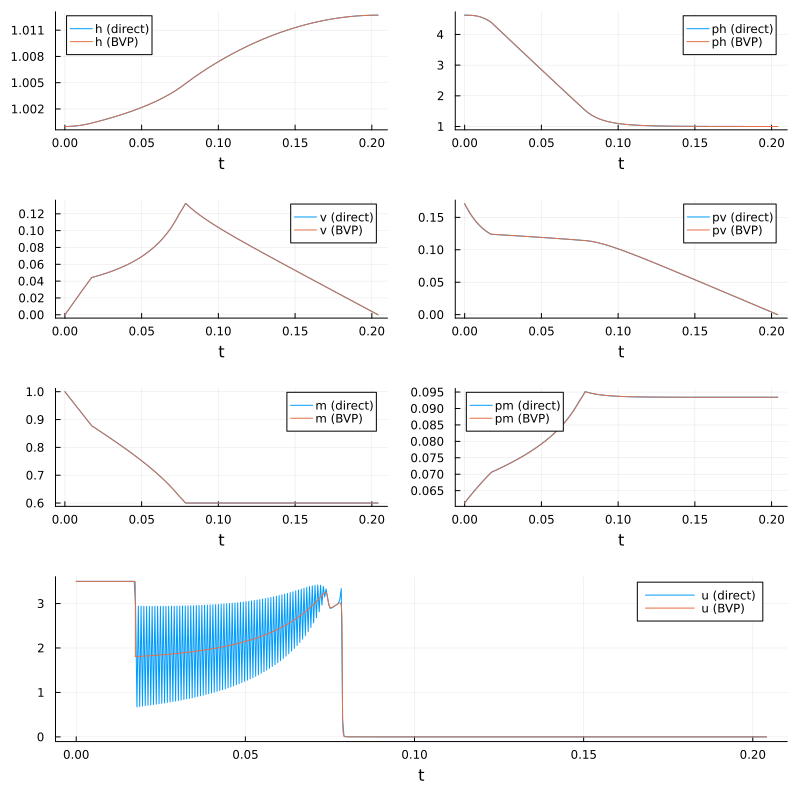

In [20]:
plt = plot(direct_sol, solution_label="(direct)", size=(800, 800))
plot!(plt, sol_bvp)

## Indirect method

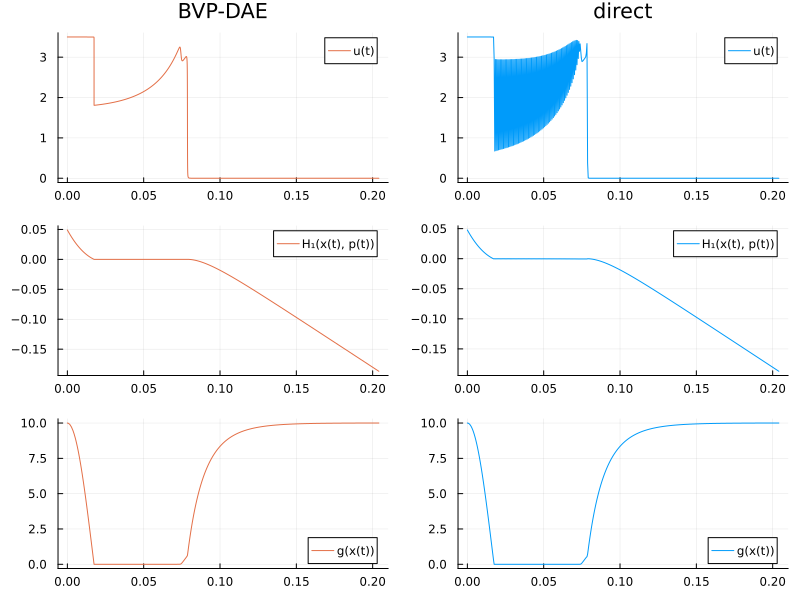

In [21]:
# info from direct

t = direct_sol.times
x = direct_sol.state
u = direct_sol.control
p = direct_sol.costate

H1 = Lift(F1)               # H1(x, p) = p' * F1(x)
φ(t) = H1(x(t), p(t))       # switching function
g(x) = -q(x[1], x[2])       # -q(h, v)

u_plot  = plot(t, u,     label = "u(t)",           color=1, title="direct")
H1_plot = plot(t, φ,     label = "H₁(x(t), p(t))", color=1)
g_plot  = plot(t, g ∘ x, label = "g(x(t))",        color=1)

plt_info_direct = plot(u_plot, H1_plot, g_plot; layout=(3,1))

# info from BVP-DAE
tf  = sol_bvp.tf
ts  = (sol_bvp.t)*tf
hs  = sol_bvp.h
vs  = sol_bvp.v
ms  = sol_bvp.m
U   = sol_bvp.u
phs = sol_bvp.ph
pvs = sol_bvp.pv
pms = sol_bvp.pm

X = [ [h, v, m] for (h, v, m) ∈ zip(hs, vs, ms) ]
P = [ [ph, pv, pm] for (ph, pv, pm) ∈ zip(phs, pvs, pms) ]

H1_bvp = H1.(X, P)
g_bvp  = g.(X)

u_plot  = plot(ts, U,      label = "u(t)",           color=2, title="BVP-DAE")
H1_plot = plot(ts, H1_bvp, label = "H₁(x(t), p(t))", color=2)
g_plot  = plot(ts, g_bvp,  label = "g(x(t))",        color=2)

plt_info_bvp = plot(u_plot, H1_plot, g_plot;  layout=(3,1))

#
plot(plt_info_bvp, plt_info_direct; layout=(1, 2), size=(800, 600))


We remark a structure of the form: Bang-Boundary-Singular-Off. We need to find the three switching times.

p0 = [4.6275833240047435, 0.16663923796057167, 0.061782408701589436]
t1 = 0.017471731250846115
t2 = 0.07394400128380448
t3 = 0.07900538328393554
tf = 0.2040494160682758


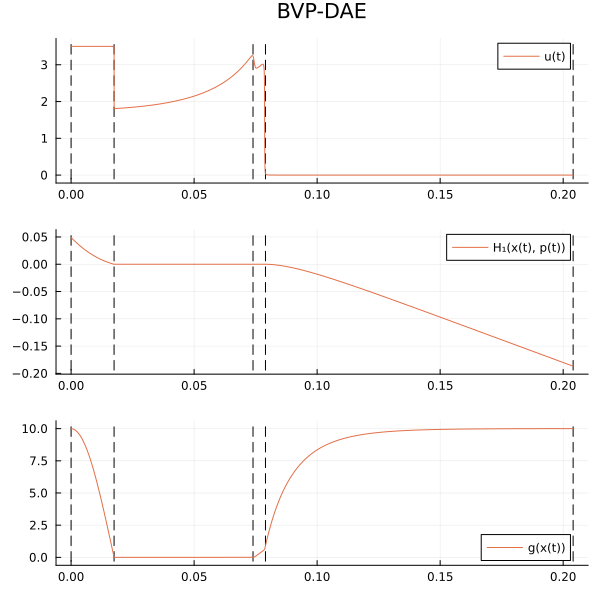

In [10]:
t13 = ts[ abs.(H1_bvp) .≤ 1e-5 ]
t12 = ts[  0 .≤ g_bvp  .≤ 1e-2 ]
p0 = p(t0)
t1 = min(t12...)
t2 = max(t12...)
t3 = max(t13...)

println("p0 = ", p0)
println("t1 = ", t1)
println("t2 = ", t2)
println("t3 = ", t3)
println("tf = ", tf)

u_plot  = plot(ts, U, label = "u(t)", color=2, title="BVP-DAE")

axis_style = (linestyle=:dash, color=:black, z_order=:back, label=false)

function add_times_to_plot!(plt)
    ymin, ymax = Plots.ylims(plt)
    plot!(plt, [t0, t0], [ymin, ymax]; axis_style...)
    plot!(plt, [t1, t1], [ymin, ymax]; axis_style...)
    plot!(plt, [t2, t2], [ymin, ymax]; axis_style...)
    plot!(plt, [t3, t3], [ymin, ymax]; axis_style...)
    plot!(plt, [tf, tf], [ymin, ymax]; axis_style...)
end

u_plot  = plot(ts, U,      label = "u(t)",           color=2, title="BVP-DAE"); add_times_to_plot!(u_plot)
H1_plot = plot(ts, H1_bvp, label = "H₁(x(t), p(t))", color=2); add_times_to_plot!(H1_plot)
g_plot  = plot(ts, g_bvp,  label = "g(x(t))",        color=2); add_times_to_plot!(g_plot)

plt_info_bvp = plot(u_plot, H1_plot, g_plot; layout=(3,1), size=(600, 600))

Now, we can define the different flows.

In [11]:
using OrdinaryDiffEq

# Controls
u0 = 0                                  # off control
u1 = Tmax                               # bang control

H0 = Lift(F0)                           # H0(x, p) = p' * F0(x)
H01  = @Lie { H0, H1 }
H001 = @Lie { H0, H01 }
H101 = @Lie { H1, H01 }
us(x, p) = -H001(x, p) / H101(x, p)     # singular control

ub(x) = -(F0⋅g)(x) / (F1⋅g)(x)          # boundary control
μ(x, p) = H01(x, p) / (F1⋅g)(x)         # multiplier associated to the state constraint g

# Flows
f0 = Flow(ocp, (x, p, tf) -> u0)
f1 = Flow(ocp, (x, p, tf) -> u1)
fs = Flow(ocp, (x, p, tf) -> us(x, p))
fb = Flow(ocp, (x, p, tf) -> ub(x), (x, u, tf) -> g(x), (x, p, tf) -> μ(x, p))

nothing

In [12]:
x0 = [ h0, v0, m0 ] # initial state

function shoot!(s, p0, t1, t2, t3, tf)

    x1, p1 = f1(t0, x0, p0, t1)
    x2, p2 = fb(t1, x1, p1, t2)
    x3, p3 = fs(t2, x2, p2, t3)
    xf, pf = f0(t3, x3, p3, tf)

    s[1] = xf[3] - mf               # final mass constraint
    s[2:3] = pf[1:2] - [ 1, 0 ]     # transversality conditions
    s[4] = g(x1)                    # g = 0 when entering the boundary arc
    s[5] = H1(x1, p1)               # H1 = H01 = 0
    s[6] = H01(x2, p2)              # at the entrance of the singular arc
    s[7] = H0(xf, pf)               # since tf is free

end
nothing

In [13]:
# Norm of the shooting function at initial guess
using LinearAlgebra: norm
s = similar(p0, 7)
shoot!(s, p0, t1, t2, t3, tf)
println("Norm of the shooting function: ‖s‖ = ", norm(s), "\n")

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase /Users/ocots/.julia/packages/SciMLBase/2N9y0/src/performance_warnings.jl:33


Norm of the shooting function: ‖s‖ = 0.027563792306818064



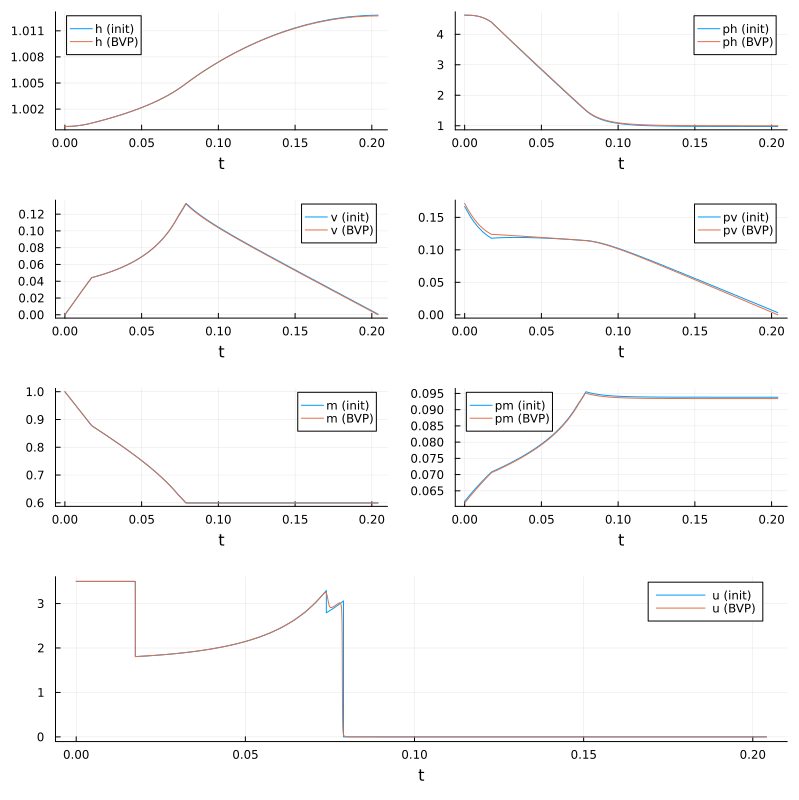

In [14]:
f = f1 * (t1, fb) * (t2, fs) * (t3, f0) # concatenation of the flows
flow_sol = f((t0, tf), x0, p0)          # compute the solution: state, costate, control...

plt_init = plot(flow_sol, solution_label="(init)", size=(800, 800))
plot!(plt_init, sol_bvp)

Finally we can solve the problem via indirect shooting.

In [15]:
using NonlinearSolve

nle = (s, ξ, λ) -> shoot!(s, ξ[1:3], ξ[4], ξ[5], ξ[6], ξ[7])   # auxiliary function
                                                               # with aggregated inputs
ξ = [ p0 ; t1 ; t2 ; t3 ; tf ]                                 # initial guess

prob = NonlinearProblem(nle, ξ)
indirect_sol = NonlinearSolve.solve(prob; abstol=1e-8, reltol=1e-8, show_trace=Val(true))

# we retrieve the costate solution together with the times
p0 = indirect_sol.u[1:3]
t1 = indirect_sol.u[4]
t2 = indirect_sol.u[5]
t3 = indirect_sol.u[6]
tf = indirect_sol.u[7]

println("p0 = ", p0)
println("t1 = ", t1)
println("t2 = ", t2)
println("t3 = ", t3)
println("tf = ", tf)

# Norm of the shooting function at solution
s = similar(p0, 7)
shoot!(s, p0, t1, t2, t3, tf)
println("Norm of the shooting function: ‖s‖ = ", norm(s), "\n")


Algorithm: NewtonRaphson(
   descent = NewtonDescent()
)

----     -------------        -----------         
Iter     f(u) inf-norm        Step 2-norm         
----     -------------        -----------         
0        2.39504829e-02       2.12199579e-314     
1        1.35095511e-01       9.34243879e-03      
2        9.36807000e-03       1.21201615e-02      


┌ Warning: Potential Rank Deficient Matrix Detected. Attempting to solve using Pivoted QR Factorization.
└ @ NonlinearSolve /Users/ocots/.julia/packages/NonlinearSolve/82B4C/src/internal/linear_solve.jl:162


3        1.33692189e-05       4.63651030e-03      
4        1.00587123e-09       6.38305103e-05      
Final    1.00587123e-09      
----------------------      
p0 = [4.62794261590887, 0.17142708846777988, 0.06122396017047794]
t1 = 0.017479972899162314
t2 = 0.0744073331082837
t3 = 0.07865510375621838
tf = 0.20404721559262207
Norm of the shooting function: ‖s‖ = 1.0538937318437445e-9



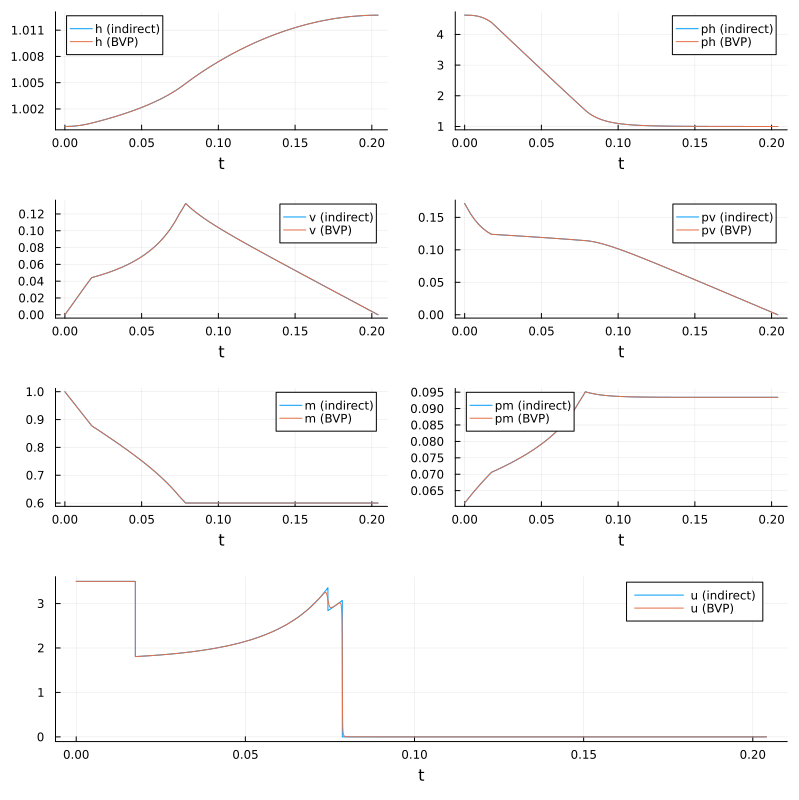

In [16]:
f = f1 * (t1, fb) * (t2, fs) * (t3, f0) # concatenation of the flows
flow_sol = f((t0, tf), x0, p0)          # compute the solution: state, costate, control...

plt_final = plot(flow_sol, solution_label="(indirect)", size=(800, 800))
plot!(plt_final, sol_bvp)

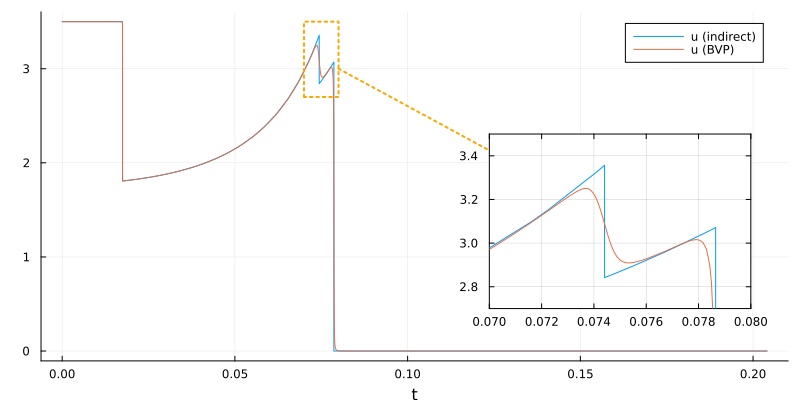

In [17]:
u_plot = plot(plt_final[7], size=(800, 400))
Plots.lens!(u_plot, [0.07, 0.08], [2.7, 3.5], inset = (1, Plots.bbox(0.6, 0.35, 0.35, 0.5)), 
    framestyle=:box, lw=2, ls=:dot, lc=:orange)